Saving apple.jpg to apple.jpg


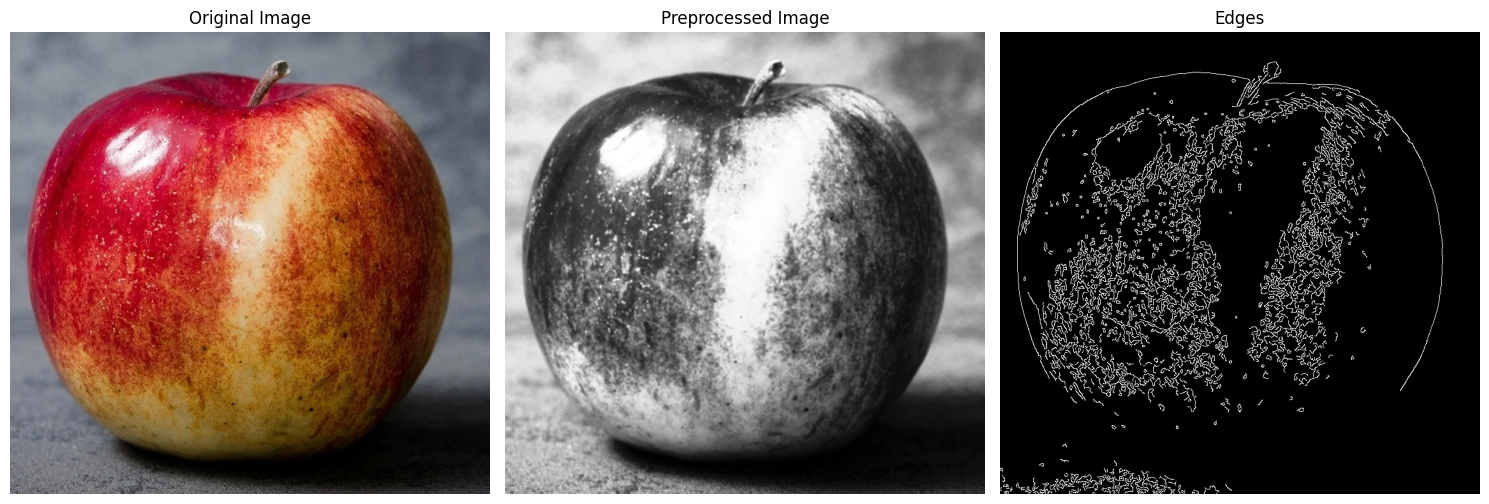

In [4]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_image(image):
    # 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 노이즈 제거 (가우시안 블러 적용)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 대비 향상 (히스토그램 평활화)
    equalized = cv2.equalizeHist(blurred)

    # 엣지 검출 (선택적)
    edges = cv2.Canny(equalized, 100, 200)

    return equalized, edges

# 파일 업로드
uploaded = files.upload()

# 업로드된 파일 이름 가져오기
file_name = next(iter(uploaded))

# 이미지 읽기
image = cv2.imread(file_name)

# 전처리 적용
preprocessed, edges = preprocess_image(image)

# 결과 표시
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(preprocessed, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

Saving apple.jpg to apple (1).jpg


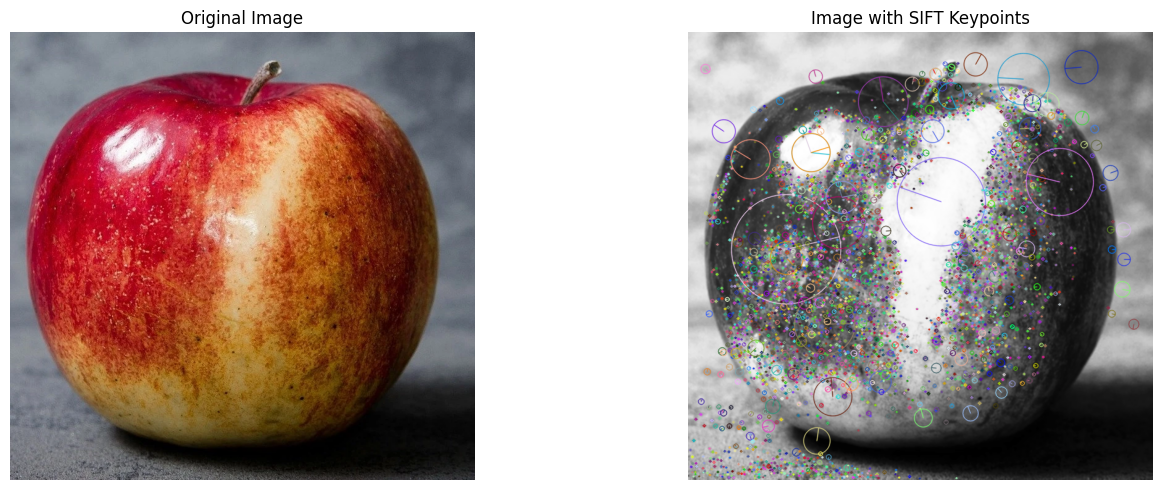

Number of keypoints detected: 4586
Shape of descriptors: (4586, 128)


In [5]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    return equalized

def extract_sift_features(image):
    # SIFT 객체 생성
    sift = cv2.SIFT_create()

    # 키포인트와 디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return keypoints, descriptors

# 파일 업로드
uploaded = files.upload()
file_name = next(iter(uploaded))

# 이미지 읽기 및 전처리
image = cv2.imread(file_name)
preprocessed = preprocess_image(image)

# SIFT 특징점 추출
keypoints, descriptors = extract_sift_features(preprocessed)

# 결과 시각화
image_with_keypoints = cv2.drawKeypoints(preprocessed, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image with SIFT Keypoints')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of keypoints detected: {len(keypoints)}")
print(f"Shape of descriptors: {descriptors.shape}")

Upload the reference (normal state) image:


Saving apple.jpg to apple (3).jpg
Upload the image to be analyzed:


Saving apple3.png to apple3 (2).png


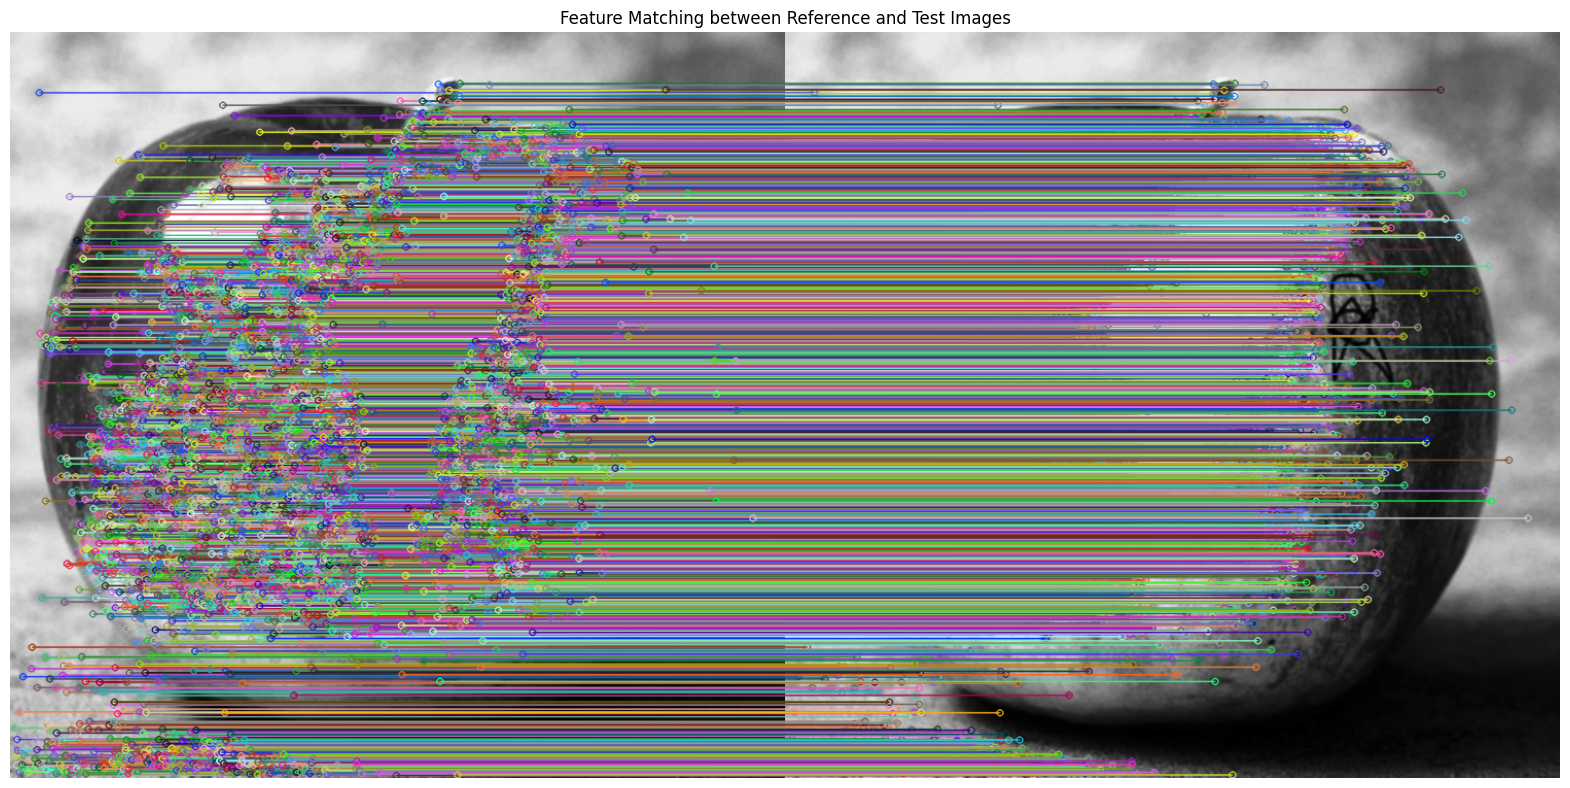

Number of good matches: 4319
Difference score: 0.0000 (0 = identical, 1 = completely different)
The images are very similar. No significant damage detected.


In [7]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    return equalized

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(desc1, desc2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

def analyze_differences(kp1, kp2, matches):
    if len(matches) == 0:
        return 0

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    inlier_ratio = sum(matchesMask) / len(matchesMask)
    return 1 - inlier_ratio  # 차이점 점수 (0에 가까울수록 유사)

# 파일 업로드
print("Upload the reference (normal state) image:")
uploaded = files.upload()
ref_filename = next(iter(uploaded))

print("Upload the image to be analyzed:")
uploaded = files.upload()
test_filename = next(iter(uploaded))

# 이미지 읽기 및 전처리
ref_image = cv2.imread(ref_filename)
test_image = cv2.imread(test_filename)

ref_preprocessed = preprocess_image(ref_image)
test_preprocessed = preprocess_image(test_image)

# SIFT 특징점 추출
ref_kp, ref_desc = extract_sift_features(ref_preprocessed)
test_kp, test_desc = extract_sift_features(test_preprocessed)

# 특징점 매칭
matches = match_features(ref_desc, test_desc)

# 차이점 분석
difference_score = analyze_differences(ref_kp, test_kp, matches)

# 결과 시각화
matched_image = cv2.drawMatches(ref_preprocessed, ref_kp, test_preprocessed, test_kp, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Feature Matching between Reference and Test Images')
plt.axis('off')
plt.show()

print(f"Number of good matches: {len(matches)}")
print(f"Difference score: {difference_score:.4f} (0 = identical, 1 = completely different)")

if difference_score < 0.3:
    print("The images are very similar. No significant damage detected.")
elif difference_score < 0.6:
    print("Some differences detected. Moderate damage may be present.")
else:
    print("Significant differences detected. High likelihood of damage.")

손상도 점수: 0.04


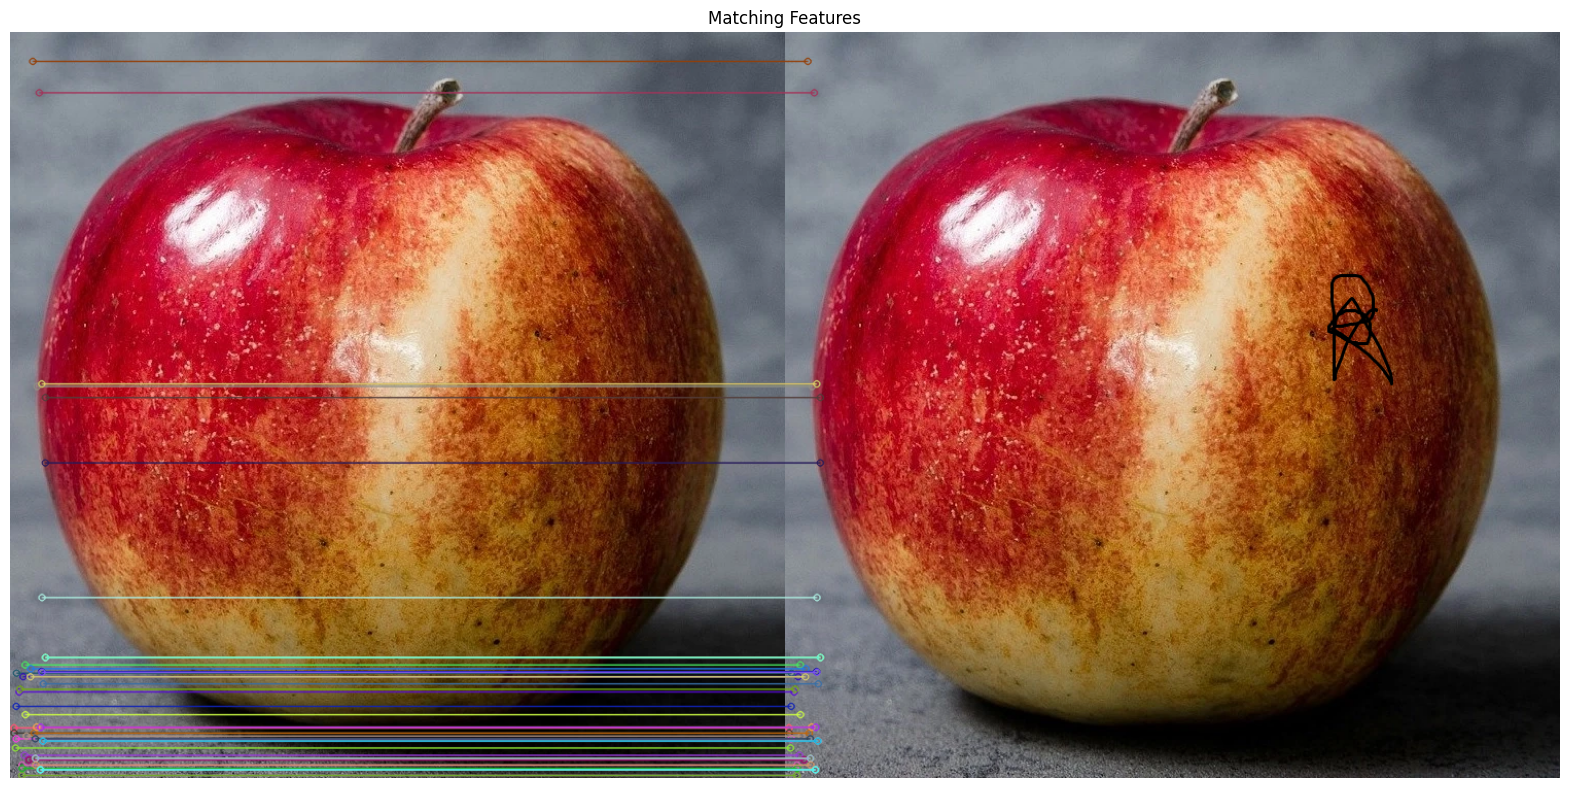

In [16]:
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 이미지 파일 경로
original_path = '/content/drive/MyDrive/KeyPoint/images/apple.jpg'
damaged_path = '/content/drive/MyDrive/KeyPoint/images/apple2.png'

def load_images(original_path, damaged_path):
    original = cv2.imread(original_path)
    damaged = cv2.imread(damaged_path)
    if original is None or damaged is None:
        raise FileNotFoundError("하나 또는 두 이미지 파일을 찾을 수 없습니다.")
    return original, damaged

# 이미지 로드
try:
    original, damaged = load_images(original_path, damaged_path)
except FileNotFoundError as e:
    print(f"오류: {e}")
    print("지정된 경로에 이미지 파일이 있는지 확인해주세요.")
    # 여기서 프로그램을 종료하거나 다른 처리를 할 수 있습니다.
    raise

# 1. 이미지 전처리
def preprocess_image(image):
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 노이즈 제거
    denoised = cv2.fastNlMeansDenoising(gray)
    # 대비 향상
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    return enhanced

original_processed = preprocess_image(original)
damaged_processed = preprocess_image(damaged)

# 2. 특징점 추출 (SIFT 사용)
def extract_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

original_keypoints, original_descriptors = extract_features(original_processed)
damaged_keypoints, damaged_descriptors = extract_features(damaged_processed)

# 3. 특징점 분석
def match_features(desc1, desc2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

matches = match_features(original_descriptors, damaged_descriptors)

# 4. 손상도 평가
def assess_damage(original_kp, damaged_kp, matches):
    if len(original_kp) == 0 or len(damaged_kp) == 0:
        return 1.0  # 최대 손상도

    match_ratio = len(matches) / min(len(original_kp), len(damaged_kp))
    damage_score = 1 - match_ratio
    return damage_score

damage_score = assess_damage(original_keypoints, damaged_keypoints, matches)

print(f"손상도 점수: {damage_score:.2f}")
# 0에 가까울수록 손상이 적음, 1에 가까울수록 손상이 심함

# 결과 시각화
def visualize_matches(img1, kp1, img2, kp2, matches):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(20,10))
    plt.imshow(img_matches)
    plt.title('Matching Features')
    plt.axis('off')
    plt.show()

visualize_matches(original, original_keypoints, damaged, damaged_keypoints, matches)

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images(original_path, damaged_path):
    original = cv2.imread(original_path)
    damaged = cv2.imread(damaged_path)
    if original is None or damaged is None:
        raise FileNotFoundError("하나 또는 두 이미지 파일을 찾을 수 없습니다.")
    return original, damaged

def extract_object(image):
    # HSV 색 공간으로 변환
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 빨간색 사과를 위한 색상 범위 (예시, 조정 필요할 수 있음)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # 마스크 생성
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # 노이즈 제거
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 마스크 적용
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    return enhanced

def extract_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(desc1, desc2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

def assess_damage(original_kp, damaged_kp, matches):
    if len(original_kp) == 0 or len(damaged_kp) == 0:
        return 1.0  # 최대 손상도

    match_ratio = len(matches) / min(len(original_kp), len(damaged_kp))
    damage_score = 1 - match_ratio
    return damage_score

def visualize_results(original, damaged, original_extracted, damaged_extracted, kp1, kp2, matches):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    axes[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(cv2.cvtColor(damaged, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Damaged Image')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(cv2.cvtColor(original_extracted, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('Extracted Original Object')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(cv2.cvtColor(damaged_extracted, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title('Extracted Damaged Object')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # 특징점 매칭 결과 시각화
    img_matches = cv2.drawMatches(original_extracted, kp1, damaged_extracted, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matching Features')
    plt.axis('off')
    plt.show()

# 메인 실행 코드
original_path = '/content/drive/MyDrive/KeyPoint/images/apple.jpg'
damaged_path = '/content/drive/MyDrive/KeyPoint/images/apple2.png'

try:
    original, damaged = load_images(original_path, damaged_path)

    # 물체 추출
    original_extracted = extract_object(original)
    damaged_extracted = extract_object(damaged)

    # 전처리
    original_processed = preprocess_image(original_extracted)
    damaged_processed = preprocess_image(damaged_extracted)

    # 특징점 추출
    original_keypoints, original_descriptors = extract_features(original_processed)
    damaged_keypoints, damaged_descriptors = extract_features(damaged_processed)

    # 특징점 매칭
    matches = match_features(original_descriptors, damaged_descriptors)

    # 손상도 평가
    damage_score = assess_damage(original_keypoints, damaged_keypoints, matches)

    print(f"손상도 점수: {damage_score:.2f}")

    # 결과 시각화
    visualize_results(original, damaged, original_extracted, damaged_extracted, original_keypoints, damaged_keypoints, matches)

except FileNotFoundError as e:
    print(f"오류: {e}")
    print("지정된 경로에 이미지 파일이 있는지 확인해주세요.")

Output hidden; open in https://colab.research.google.com to view.

In [19]:
import os
import cv2

def load_image(image_path):
    """Load an image from a file path."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {'/content/drive/MyDrive/KeyPoint/images/apple.jpg'}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    return image


In [20]:
import cv2

def preprocess_image(image):
    """Preprocess the image by applying noise reduction and contrast enhancement."""
    # Apply Gaussian Blur for noise removal
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert to grayscale
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    # Apply histogram equalization for contrast enhancement
    enhanced = cv2.equalizeHist(gray)
    return enhanced
